In [23]:
is_notebook_mode = 'get_ipython' in globals()

In [24]:
from pathlib import Path
Path("figure").mkdir(exist_ok=True)
Path("visual").mkdir(exist_ok=True)

In [25]:
import os
from argparse import Namespace
from pathlib import Path

import pandas as pd

assert Namespace



# Get all files with format '*.latency.csv' from root_dir
# root_dir = Path("fig11-abalation-log")
root_dir = Path("result")
latency_file_paths = sorted(list(root_dir.glob("*.latency.csv")))
experiment_log_paths = sorted(list(root_dir.glob("*.log")))
columns = ['backend', 'rate', 'target', 'attainment', 'latency']

In [26]:
dfs = []
namespaces = []
for latency_file_path, experiment_log_path in zip(latency_file_paths, experiment_log_paths):
    # read experiment_log_path and log the namespace
    # with open(experiment_log_path, 'r') as f:
    #     exp_args = f.read()
    #     exp_args = eval(exp_args)
    #     namespaces.append(exp_args)

    try:
        df = pd.read_csv(latency_file_path)
    except pd.errors.EmptyDataError:
        pass
    dfs.append(df)

In [27]:
big_df = pd.concat(dfs, ignore_index=True)
big_df['ngpu'] = big_df['tp_prefill'] * big_df['pp_prefill'] + big_df['tp_decode'] * big_df['pp_decode']
big_df['per_gpu_rate'] = big_df['rate'] / big_df['ngpu']
big_df['goodput@90'] = big_df.apply(
    lambda x: x['rate'] / x['ngpu'] if x['attainment'] >= 90 else 0,
    axis=1,
)
big_df['target'] = big_df['target'].apply(eval)
chosen_per_gpu_rate = 1
big_df = big_df[big_df['per_gpu_rate'] == chosen_per_gpu_rate]

In [28]:
big_df

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90
175,distserve,OPT-13B,prefill,12.0,200.0,9.083333,1,1,1,2,3,4.0,0.0
176,distserve,OPT-13B,decode,12.0,100.0,65.083333,1,1,1,2,3,4.0,0.0
177,distserve,OPT-13B,both,12.0,"(200.0, 100.0)",5.666667,1,1,1,2,3,4.0,0.0
178,distserve,OPT-13B,prefill,12.0,80.0,2.750000,1,1,1,2,3,4.0,0.0
179,distserve,OPT-13B,decode,12.0,40.0,6.000000,1,1,1,2,3,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5820,vllm,OPT-13B,decode,8.0,371.657531,95.000000,2,1,0,0,2,4.0,4.0
5821,vllm,OPT-13B,prefill,8.0,508.697275,98.000000,2,1,0,0,2,4.0,4.0
5822,vllm,OPT-13B,decode,8.0,432.904646,98.000000,2,1,0,0,2,4.0,4.0
5823,vllm,OPT-13B,prefill,8.0,613.994735,99.000000,2,1,0,0,2,4.0,4.0


In [29]:
slos = [0.4, 0.6, 0.8, 1, 1.2]
targets = [
    (200 * slo, 100 * slo)
    for slo in slos
]
target_to_slo = {
    target: slo
    for target, slo in zip(targets, slos)
}

In [30]:
big_df = big_df[big_df['target'].isin(targets)]
big_df = big_df.copy()

In [31]:
big_df['slo'] = big_df['target'].apply(lambda x: target_to_slo[x])

In [32]:
max_machine = 4
max_gpu_per_node = 8


def can_fit_low_affinity_distserve(x):
    a, b, c, d = x['tp_prefill'], x['pp_prefill'], x['tp_decode'], x['pp_decode']
    for pp_common in range(1, max_machine + 1):
        bp = b / pp_common
        dp = d / pp_common
        # If either bp or dp is not int, skip
        if int(bp) != bp or int(dp) != dp:
            continue
        # Check if the segment can be placed inside a node
        if a * bp + c * dp <= max_gpu_per_node:
            return True
        pass
    return False


def can_fit_low_affinity(x):
    if x['backend'] == 'distserve':
        return can_fit_low_affinity_distserve(x)
    else:
        return True
    pass


big_df['low_affin'] = big_df.apply(can_fit_low_affinity, axis=1)

In [33]:
big_df

,backend,model_type,pd,rate,target,attainment,tp_prefill,pp_prefill,tp_decode,pp_decode,ngpu,per_gpu_rate,goodput@90,slo,low_affin
177,distserve,OPT-13B,both,12.0,"(200.0, 100.0)",5.666667,1,1,1,2,3,4.0,0.0,1.0,True
180,distserve,OPT-13B,both,12.0,"(80.0, 40.0)",0.416667,1,1,1,2,3,4.0,0.0,0.4,True
183,distserve,OPT-13B,both,12.0,"(120.0, 60.0)",0.750000,1,1,1,2,3,4.0,0.0,0.6,True
186,distserve,OPT-13B,both,12.0,"(160.0, 80.0)",2.416667,1,1,1,2,3,4.0,0.0,0.8,True
189,distserve,OPT-13B,both,12.0,"(240.0, 120.0)",11.916667,1,1,1,2,3,4.0,0.0,1.2,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5802,vllm,OPT-13B,both,8.0,"(200.0, 100.0)",9.750000,2,1,0,0,2,4.0,0.0,1.0,True
5805,vllm,OPT-13B,both,8.0,"(80.0, 40.0)",0.375000,2,1,0,0,2,4.0,0.0,0.4,True
5808,vllm,OPT-13B,both,8.0,"(120.0, 60.0)",2.000000,2,1,0,0,2,4.0,0.0,0.6,True
5811,vllm,OPT-13B,both,8.0,"(160.0, 80.0)",4.750000,2,1,0,0,2,4.0,0.0,0.8,True


In [34]:
figure_11_right_df = big_df.copy()

In [35]:
figure_11_distserve_high = figure_11_right_df[
    (figure_11_right_df['backend'] == 'distserve')
]
figure_11_distserve_low = figure_11_right_df[
    (figure_11_right_df['backend'] == 'distserve') & (figure_11_right_df['low_affin'])
]
figure_11_vllm_high = figure_11_right_df[
    (figure_11_right_df['backend'] == 'vllm')
]
figure_11_vllm_low = figure_11_right_df[
    (figure_11_right_df['backend'] == 'vllm') & (figure_11_right_df['low_affin'])
]

In [36]:
def get_top_config(df):
    strictest_slo = min(slos)
    r = df[df['slo'] == strictest_slo].sort_values(
        by=['goodput@90', 'attainment'],
        ascending=False,
    ).iloc[0][[
        "tp_prefill",
        "pp_prefill",
        "tp_decode",
        "pp_decode",
    ]]
    return r

In [37]:
big_df = big_df.sort_values(by=['per_gpu_rate', 'slo', ], ascending=False)

In [38]:
import plotly.graph_objects as go

fig = go.Figure()
configs = figure_11_distserve_high[['tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode']].drop_duplicates()
slo_vals = list(big_df['slo'].unique())

df = figure_11_distserve_high
for tp_prefill, pp_prefill, tp_decode, pp_decode in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    config_df = config_df.sort_values(by=['slo'], ascending=False)
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['slo'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}-distserve"
    ))

# fig add title
fig.update_layout(
    title="DistServe",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)
fig.update_layout(
    xaxis=dict(range=[max(slo_vals), min(slo_vals)]),
)  # Set the range manually

# Export to html
fig.write_html("visual/figure_11_distserve_high.slo.html")
if is_notebook_mode:
    fig.show()

In [39]:
import plotly.graph_objects as go

fig = go.Figure()
configs = figure_11_vllm_high[['tp_prefill', 'pp_prefill']].drop_duplicates()
slo_vals = list(big_df['slo'].unique())

df = figure_11_vllm_high
for tp_prefill, pp_prefill in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill)
        ]
    config_df = config_df.sort_values(by=['slo'], ascending=False)
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['slo'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}-vLLM"
    ))

# fig add title
fig.update_layout(
    title="vLLM",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)
fig.update_layout(
    xaxis=dict(range=[max(slo_vals), min(slo_vals)]),
)  # Set the range manually

fig.write_html("visual/figure_11_vllm_high.slo.html")
if is_notebook_mode:
    fig.show()
# Export to html

In [40]:
import plotly.graph_objects as go

fig = go.Figure()
configs = figure_11_distserve_high[['tp_prefill', 'pp_prefill', 'tp_decode', 'pp_decode']].drop_duplicates()
slo_vals = list(big_df['slo'].unique())

df = figure_11_distserve_high
for tp_prefill, pp_prefill, tp_decode, pp_decode in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    config_df = config_df.sort_values(by=['slo'], ascending=False)
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['slo'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}-distserve"
    ))

configs = figure_11_vllm_high[['tp_prefill', 'pp_prefill']].drop_duplicates()
slo_vals = list(big_df['slo'].unique())

df = figure_11_vllm_high
for tp_prefill, pp_prefill in configs.values:
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill)
        ]
    config_df = config_df.sort_values(by=['slo'], ascending=False)
    # plot this inside a plotly plot
    fig.add_trace(go.Scatter(
        x=config_df['slo'], y=config_df['attainment'],
        mode='lines+markers', name=f"p{tp_prefill}{pp_prefill}-vLLM"
    ))

# fig add title
fig.update_layout(
    title="DistServe and vLLM",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    legend_title="Configuration"
)
fig.update_layout(
    xaxis=dict(range=[max(slo_vals), min(slo_vals)]),
)  # Set the range manually
fig.write_html("visual/figure_11_distserve_vllm_high.slo.html")
if is_notebook_mode:
    fig.show()
# Export to html

In [41]:
def get_top_config(df):
    strictest_slo = min(slos)
    r = df[df['slo'] == strictest_slo].sort_values(
        by=['goodput@90', 'attainment'],
        ascending=False,
    ).iloc[0][[
        "tp_prefill",
        "pp_prefill",
        "tp_decode",
        "pp_decode",
    ]]
    return r

def add_plotly_trace(fig, df: 'DataFrame', trace: str):
    tp_prefill, pp_prefill, tp_decode, pp_decode = get_top_config(df)
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    config_df = config_df.sort_values(by=['slo'], ascending=False)
    if 'vllm' in trace:
        name = f"{trace}-p{tp_prefill}{pp_prefill}"
        pass
    else:
        name = f"{trace}-p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}"
        pass

    fig.add_trace(go.Scatter(
        x=config_df['slo'], y=config_df['attainment'],
        mode='lines+markers', name=name,
    ))
    return

In [42]:
import plotly.graph_objects as go

fig = go.Figure()
add_plotly_trace(fig, figure_11_distserve_high, "disthigh")
add_plotly_trace(fig, figure_11_distserve_low, "distlow")
add_plotly_trace(fig, figure_11_vllm_high, "vllm++")
add_plotly_trace(fig, figure_11_vllm_low, "vllm")
fig.update_layout(
    title=f"Figure 11: Abalation Study - SLO with per-GPU rate = {chosen_per_gpu_rate}"
          f"<br>"
          f"<sup>"
          f"The figure shows that DistHigh > DistLow > vLLM++ > vLLM (vLLM++ and vLLM overlaps) </sup>",
    xaxis_title="Per-GPU Rate (tokens/s)",
    yaxis_title="Attainment (%)",
    xaxis=dict(range=[max(slo_vals), min(slo_vals)]),
    legend_title="Configuration"
)
fig.write_html("visual/figure_11b.html")
if is_notebook_mode:
    fig.show()

In [43]:

def add_matplotlib_trace(fig, df: 'DataFrame', trace: str):
    tp_prefill, pp_prefill, tp_decode, pp_decode = get_top_config(df)
    config_df = df[
        (df['tp_prefill'] == tp_prefill) & (df['pp_prefill'] == pp_prefill) &
        (df['tp_decode'] == tp_decode) & (df['pp_decode'] == pp_decode)
        ]
    config_df = config_df.sort_values(by=['slo'], ascending=False)
    if 'vllm' in trace:
        name = f"{trace}-p{tp_prefill}{pp_prefill}"
        pass
    else:
        name = f"{trace}-p{tp_prefill}{pp_prefill}{tp_decode}{pp_decode}"
        pass

    fig.plot(
        config_df['slo'], 
        config_df['attainment'],
        label=name,
        marker='o',
    )
    return config_df['attainment'].tolist()

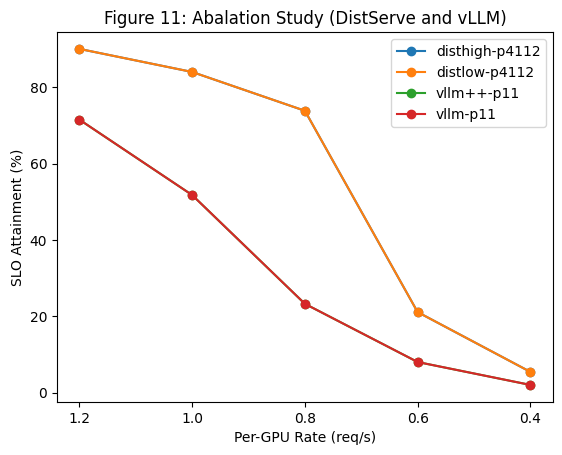

In [44]:
import matplotlib.pyplot as plt

# Plot a line chart with 4 curves
# x-axis: per_gpu_rate
# y-axis: attainment

fig, ax = plt.subplots()
a = add_matplotlib_trace(ax, figure_11_distserve_high, "disthigh")
b = add_matplotlib_trace(ax, figure_11_distserve_low, "distlow")
c = add_matplotlib_trace(ax, figure_11_vllm_high, "vllm++")
d = add_matplotlib_trace(ax, figure_11_vllm_low, "vllm")
plt.title("Figure 11: Abalation Study (DistServe and vLLM)")
plt.xlabel("Per-GPU Rate (req/s)")
plt.ylabel("SLO Attainment (%)")
plt.xticks(slos)
plt.gca().invert_xaxis()
plt.legend()

# save the plot 
fig.savefig("figure/figure_11b.png")

if is_notebook_mode:
    plt.show()

In [45]:
data_points = {
    "dist++": a,
    "dist": b,
    "vllm++": c,
    "vllm": d,
}
with open("figure/figure_11b.json", "w") as f:
    import json

    json.dump(data_points, f)